In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import Tensor

from tqdm.notebook import tqdm
from typing import Type, Sequence, Callable
from itertools import pairwise
from sklearn.metrics import mean_squared_error
import math

Here we are going to want to be precise, so let us change the default torch type to double precission (64-bit) float.

In [2]:
torch.set_default_dtype(torch.float64)

# RNNs INDP tutorial

by Dylan and Dean @ Polavieja Lab

Here we will go through a tutorial of how Recurrent Neural Networks (RNNs) work. RNNs are a form of neural network that is well suited to timeseries data, because its architecture allows for each predicted timestep to take into account previous timesteps.

We'll use the harmonic oscillator as the time series we are trying to model.

Inspired by:

- www.datatechnotes.com/2018/12/rnn-example-with-keras-simplernn-in.html
- Coursera Sequence Models course: coursera.org
- en.wikipedia.org/wiki/Harmonic_oscillator
- stackoverflow.com/questions/42624701/python-numerically-solved-harmonic-oscillator-graph-generates-unwanted-results
- https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

Special thanks to Panos for reviewing this tutorial!

## First we generate a timeseries

From wikipedia:

"In classical mechanics, a harmonic oscillator is a system that, when displaced from its equilibrium position, experiences a restoring force F proportional to the displacement x:

F = -k * x, 
where k is a positive constant.

If F is the only force acting on the system, the system is called a simple harmonic oscillator, and it undergoes simple harmonic motion: sinusoidal oscillations about the equilibrium point, with a constant amplitude and a constant frequency (which does not depend on the amplitude)."

In [3]:
# The behaviour of this timeseries varies a lot with these parameters
number_of_datapoints = 100
time_change = 0.2

In [4]:
def generate_harmonic_oscillator(time_change: float, number_of_datapoints: int):
    # Initialise lists to store outputs for plotting
    displacement_list: list[float] = [0.1]  # start with some displacement
    velocity_list: list[float] = []

    # Initialise parameters
    velocity = 0  # Velocity starts at zero
    time_change = time_change  # Change in time
    konstant = 1  # constant

    for i in range(number_of_datapoints):
        # Calculate the Euler approximation
        force = -konstant * displacement_list[i]
        displacement = displacement_list[i] + time_change * velocity
        velocity = velocity + time_change * force

        # Append to lists
        displacement_list.append(displacement)
        velocity_list.append(velocity)

    return displacement_list, velocity_list

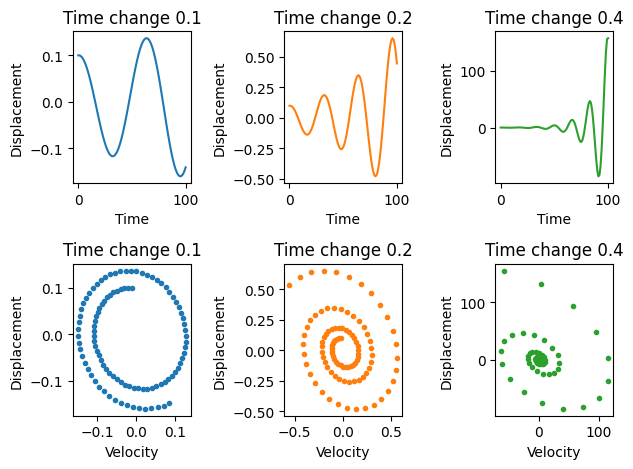

In [5]:
# You will notice that the 'harmonic' oscillations diverge, how much is determined by the size of the time change

fig, axs = plt.subplots(2, 3)

small_dt = time_change / 2
small_time_change = generate_harmonic_oscillator(small_dt, number_of_datapoints)

medium_dt = time_change
medium_time_change = generate_harmonic_oscillator(medium_dt, number_of_datapoints)

large_dt = time_change * 2
large_time_change = generate_harmonic_oscillator(large_dt, number_of_datapoints)

axs[0, 0].plot(small_time_change[0], "C0-")
axs[0, 0].set_title(f"Time change {small_dt}")
axs[0, 1].plot(medium_time_change[0], "C1-")
axs[0, 1].set_title(f"Time change {medium_dt}")
axs[0, 2].plot(large_time_change[0], "C2-")
axs[0, 2].set_title(f"Time change {large_dt}")

axs[1, 0].plot(small_time_change[1], small_time_change[0][:-1], "C0.")
axs[1, 0].set_title(f"Time change {small_dt}")
axs[1, 1].plot(medium_time_change[1], medium_time_change[0][:-1], "C1.")
axs[1, 1].set_title(f"Time change {medium_dt}")
axs[1, 2].plot(large_time_change[1], large_time_change[0][:-1], "C2.")
axs[1, 2].set_title(f"Time change {large_dt}")

for ax in axs[0]:
    ax.set(xlabel="Time", ylabel="Displacement")

for ax in axs[1]:
    ax.set(xlabel="Velocity", ylabel="Displacement")


fig.tight_layout()

## Prepare the dataset for modelling

1. Split into train and test

In [6]:
training_portion = 80  # Our number of datapoints is 100
train = np.asarray(medium_time_change[0][:training_portion])[:, None]
test = np.asarray(medium_time_change[0][training_portion:])[:, None]

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (80, 1)
Test shape: (21, 1)


2. Split into X and Y

In [7]:
# Prepare the input X and target Y
def get_XY(dat: np.ndarray, time_steps: int):
    # Indices of target array
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]
    # Prepare X
    rows_x = len(Y)
    X = dat[range(time_steps * rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    return X, Y


trainX, trainY = get_XY(train, 3)
testX, testY = get_XY(test, 3)

## Define a RNN

We introduce a RNN from scratch using Linear/Dense layers. That will allow us to get a better grasp of what the network is doing.

In [8]:
class RNN(nn.Module):
    def __init__(
        self,
        input_shape: Sequence[int],
        hidden_units: int,
        hidden_activation: Type[nn.Module] = nn.Identity,
        dense_units: Sequence[int] = [1],
        dense_activation: Sequence[Type[nn.Module]] = [nn.Identity],
    ) -> None:
        super().__init__()

        assert len(dense_units) == len(dense_activation)

        self.hidden_units = hidden_units
        self.time_steps = input_shape[0]

        self.recursive_layer = nn.Sequential(
            nn.Linear(
                in_features=input_shape[1] + hidden_units, out_features=hidden_units
            ),
            hidden_activation(),
        )

        dense_layers = [
            nn.Linear(in_features=hidden_units, out_features=dense_units[0]),
            dense_activation[0](),
        ]
        for number, (in_feat, out_feat) in enumerate(pairwise(dense_units), 1):
            dense_layers.append(nn.Linear(in_features=in_feat, out_features=out_feat))
            dense_layers.append(dense_activation[number]())
        self.dense_layers = nn.Sequential(*dense_layers)

    def forward(self, x: Tensor, hidden_state: Tensor) -> tuple[Tensor, Tensor]:
        for index in range(self.time_steps):
            combined = torch.cat((x[:, index], hidden_state), 1)
            hidden_state = self.recursive_layer(combined)
        output = self.dense_layers(hidden_state)
        return output, hidden_state

    def init_hidden(self, x: Tensor) -> Tensor:
        return torch.zeros((x.shape[0], self.hidden_units))

    def predict(self, x: Tensor) -> Tensor:
        initial_hidden = self.init_hidden(x)
        prediction, _ = self.forward(x, initial_hidden)
        return prediction

In [9]:
demo_model = RNN(
    input_shape=(3, 1),
    hidden_units=2,
    hidden_activation=nn.Identity,
    dense_units=(1,),
    dense_activation=[nn.Identity],
)
demo_model

RNN(
  (recursive_layer): Sequential(
    (0): Linear(in_features=3, out_features=2, bias=True)
    (1): Identity()
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): Identity()
  )
)

Weights are initialised randomly and we can access them with the the weight and bias parameters in each of the layers.

In [10]:
def get_weights(model: RNN) -> Sequence[np.ndarray]:
    wx = (model.recursive_layer[0].weight.data[:, 0]).view(1, 2)
    wh = model.recursive_layer[0].weight.data[:, 1:].T
    bh = model.recursive_layer[0].bias.data
    wy = model.dense_layers[0].weight.data.T
    by = model.dense_layers[0].bias.data

    print(f"{wx = }\n{wh = }\n{bh = }\n{wy =}\n{by = }")
    return [item.numpy() for item in [wx, wh, bh, wy, by]]


wx, wh, bh, wy, by = get_weights(demo_model)

wx = tensor([[-0.1164,  0.2451]])
wh = tensor([[ 0.4396, -0.0440],
        [ 0.0372, -0.5556]])
bh = tensor([-0.3675, -0.2712])
wy =tensor([[ 0.1033],
        [-0.3613]])
by = tensor([0.4126])


# So what's happening inside the network?

We take the weights we obtained previously and use them to see what the model would be doing with them
at time step 3

* Note that this version of the RNN does not include activation functions - we'll add those back in later

In [11]:
x = np.array(trainX[3])
# Reshape the input to the required sample_size x time_steps x features
x_input = Tensor(x).view(1, 3, 1)
# The model needs an initial hidden state as input, which we initialise with the init_hidden
# method we implemented in the class.
y_pred_model = demo_model.predict(x_input)
y_pred_model = y_pred_model.detach().numpy()

h0 = 0
h1 = np.dot(x[0], wx) + h0 + bh
h2 = np.dot(x[1], wx) + np.dot(h1, wh) + bh
h3 = np.dot(x[2], wx) + np.dot(h2, wh) + bh
o3 = np.dot(h3, wy) + by

print(f"{h1 = }\n{h2 = }\n{h3 = }")

print("Prediction from network ", y_pred_model)
print("Prediction from our computation ", o3)

h1 = array([-0.36466484, -0.27715134])
h2 = array([-0.53257237, -0.11285265])
h3 = array([-0.59767216, -0.20224042])
Prediction from network  [[0.42396254]]
Prediction from our computation  [0.42396254]


We are going to train the network. We begin by introducing the training loop. Thanks to the predict method we added to the SimpleRNN class, the loop will be pretty simple.

In [13]:
def train_loop(
    model: RNN,
    x_train: Tensor,
    target: Tensor,
    epochs: int,
    optimizer: torch.optim.Optimizer,
    loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
) -> list[float]:
    train_loss: list[float] = []
    model.train()

    with tqdm(range(epochs), unit="epoch") as tepochs:
        tepochs.set_description("Training")
        for epoch in tepochs:
            prediction = model.predict(x_train)
            optimizer.zero_grad()

            loss = loss_fn(prediction, target)
            loss.backward()
            optimizer.step()

            tepochs.set_postfix(loss=loss.item())

            train_loss.append(loss.item())

    return train_loss

Now we initialise a network, choose an optimizer and a loss function, and train it!

In [14]:
model = RNN(
    hidden_units=2,
    dense_units=[1],
    input_shape=(3, 1),
    hidden_activation=nn.Tanh,
    dense_activation=[nn.Identity],
)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
model

RNN(
  (recursive_layer): Sequential(
    (0): Linear(in_features=3, out_features=2, bias=True)
    (1): Tanh()
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=2, out_features=1, bias=True)
    (1): Identity()
  )
)

In [15]:
x_train = torch.tensor(trainX)
y_train = torch.tensor(trainY)
train_loss = train_loop(
    model, x_train, y_train, epochs=200, optimizer=optimizer, loss_fn=loss_fn
)

  0%|          | 0/200 [00:00<?, ?epoch/s]

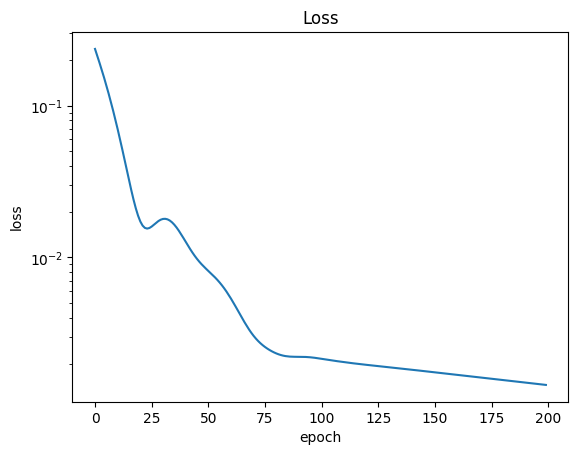

In [16]:
ax = plt.subplot()
ax.plot(train_loss)
_ = ax.set(yscale="log", title="Loss", ylabel="loss", xlabel="epoch")

# Adding activation functions

We'll use two activation functions: tanh and linear output

Obtain the weights the model arrived at after training

In [17]:
wx, wh, bh, wy, by = get_weights(model)

wx = tensor([[-0.0334,  1.2568]])
wh = tensor([[-0.0500, -0.3454],
        [-0.1880, -0.0893]])
bh = tensor([0.4093, 0.3370])
wy =tensor([[0.0801],
        [0.8924]])
by = tensor([-0.2139])


Here we'll put together what we saw earlier about how input data flows through a network at time 3 and generalise this to any time, while also adding activation functions

In [18]:
for t in range(len(testX)):
    x = trainX[t]
    # Reshape the input to the required sample_size x time_steps x features
    x_input = torch.tensor(x).view(1, 3, 1)

    with torch.no_grad():
        y_pred_model = model.predict(x_input)

    h0 = 0
    h1 = np.tanh(np.dot(x[0], wx) + h0 + bh)
    h2 = np.tanh(np.dot(x[1], wx) + np.dot(h1, wh) + bh)
    h3 = np.tanh(np.dot(x[2], wx) + np.dot(h2, wh) + bh)
    o3 = 1 * (np.dot(h3, wy) + by)  # linear output

    print(
        f"Difference between our calculations and the pytorch model: {float(abs(y_pred_model-o3))}"
    )

Difference between our calculations and the pytorch model: 5.551115123125783e-17
Difference between our calculations and the pytorch model: 0.0
Difference between our calculations and the pytorch model: 0.0
Difference between our calculations and the pytorch model: 2.7755575615628914e-17
Difference between our calculations and the pytorch model: 0.0
Difference between our calculations and the pytorch model: 5.551115123125783e-17


There is *hopefully* only a small difference between what we calculated and what the pytorch model gave us

Now that we've got a sense of what the model is doing, let's see how well it did overall

In [19]:
def print_error(
    trainY: np.ndarray,
    testY: np.ndarray,
    train_predict: Tensor,
    test_predict: Tensor,
):
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))

    print(f"Train RMSE: {train_rmse:.3f} RMSE")
    print(f"Test RMSE: {test_rmse:.3f} RMSE")


# make predictions
with torch.no_grad():
    train_predict = model.predict(torch.tensor(trainX))
    test_predict = model.predict(torch.tensor(testX))
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.038 RMSE
Test RMSE: 0.124 RMSE


Those numbers are not very informative - a nice thing about time series is plotting the predicted values over the actual values

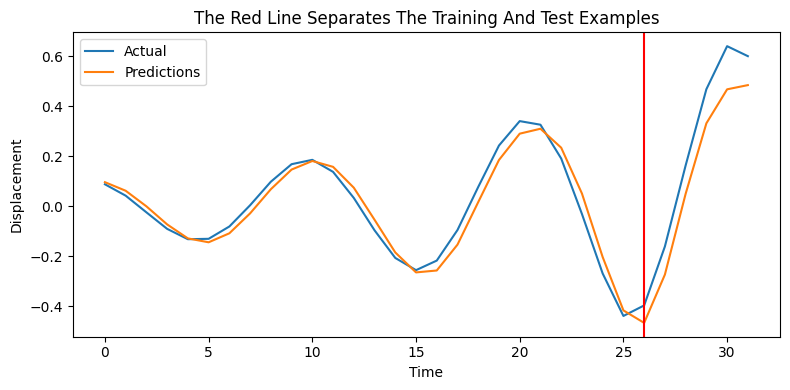

In [20]:
def plot_result(
    trainY: np.ndarray,
    testY: np.ndarray,
    train_predict: Tensor,
    test_predict: Tensor,
):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot()
    ax.plot(np.append(trainY, testY), label="Actual")
    ax.plot(np.append(train_predict, test_predict), label="Predictions")
    ax.axvline(x=len(trainY), color="r")
    ax.legend()
    ax.set(
        xlabel="Time",
        ylabel="Displacement",
        title="The Red Line Separates The Training And Test Examples",
    )
    fig.tight_layout()


plot_result(trainY, testY, train_predict, test_predict)

# Not bad! But we can do better

Next we'll look at some of the levers we can pull to improve our network.

- The BetterRNN class now gives the network a whole other layer 
- We can also increase the number of RNN units
- What else can you think of that would improve the network?

In [21]:
better_model = RNN(
    input_shape=(3, 1),
    hidden_units=20,
    hidden_activation=nn.Tanh,
    dense_units=(10, 1),
    dense_activation=[nn.Tanh, nn.Identity],
)
print(better_model)
optimizer = torch.optim.Adam(params=better_model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

train_loss = train_loop(
    better_model,  # type: ignore
    x_train,
    y_train,
    epochs=200,
    optimizer=optimizer,
    loss_fn=loss_fn,
)

RNN(
  (recursive_layer): Sequential(
    (0): Linear(in_features=21, out_features=20, bias=True)
    (1): Tanh()
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Identity()
  )
)


  0%|          | 0/200 [00:00<?, ?epoch/s]

In [22]:
# make predictions
with torch.no_grad():
    train_predict = better_model.predict(torch.tensor(trainX))
    test_predict = better_model.predict(torch.tensor(testX))
# Mean square error
print_error(trainY, testY, train_predict, test_predict)

Train RMSE: 0.004 RMSE
Test RMSE: 0.011 RMSE


Much lower than before - but what does it look like?

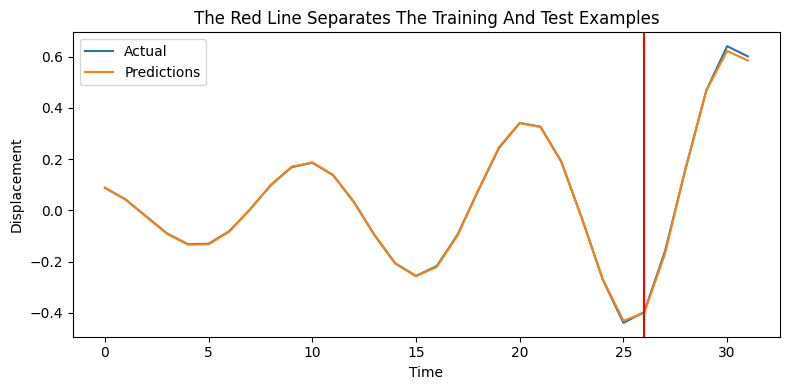

In [23]:
plot_result(trainY, testY, train_predict, test_predict)

It got better!